<a href="https://colab.research.google.com/github/ashok2216-A/emotional_audio_classification/blob/main/Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
key = {"username":"ashokkumarbibbab","key":"be92f2ff991ae66c0b5e7357a65b9444"}
with open('kaggle.json', 'w') as f:
    json.dump(key, f)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

100% 427M/428M [00:20<00:00, 23.4MB/s]
100% 428M/428M [00:20<00:00, 21.7MB/s]


In [ ]:
%%capture
!unzip /content/toronto-emotional-speech-set-tess.zip

In [ ]:
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import numpy as np
import librosa
from IPython.display import Audio
import pandas as pd
import numpy as np
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Path to create the folders in
path = '/content/raw_audio_data'
# List of folder names to create
folders = ['Neutral', 'Pleasant_Suprised', 'Happy', 'Sad', 'Angry', 'Fear', 'Disgust']
# Create each folder
for folder in folders:
    os.makedirs(os.path.join(path, folder))

In [ ]:
# Get a list of files in the source folder
files = glob.glob('/content/TESS Toronto emotional speech set data/YAF_sad/*.wav')
# Move each file to the destination folder
for file in files:
    shutil.move(file, '/content/raw_audio_data/Sad')

In [ ]:
def create_zip_file(folder_path, output_zip_file):
  with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zip_file:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        arcname = os.path.relpath(file_path, folder_path)
        zip_file.write(file_path, arcname)

create_zip_file('/content/raw_audio_data', '/content/raw_audio_data.zip')

In [ ]:
def audio_waveframe(file_path):
    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path)
    # Calculate the duration of the audio file
    duration = len(audio_data) / sampling_rate
    # Create a time array for plotting
    time = np.arange(0, duration, 1/sampling_rate)
    # Plot the waveform
    plt.figure(figsize=(30, 4))
    plt.plot(time, audio_data, color='blue')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plot = plt.show()
    return plot

def spectrogram(file_path):
    # Compute the short-time Fourier transform (STFT)
    n_fft = 500  # Number of FFT points 2048
    hop_length = 1  # Hop length for STFT 512
    audio_data, sampling_rate = librosa.load(file_path)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    # Convert the magnitude spectrogram to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    # Plot the spectrogram
    plt.figure(figsize=(30, 6))
    librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plot = plt.show()
    return plot

def audio_analysis(file_path):
    aw = audio_waveframe(file_path)
    spg = spectrogram(file_path)
    return aw, spg

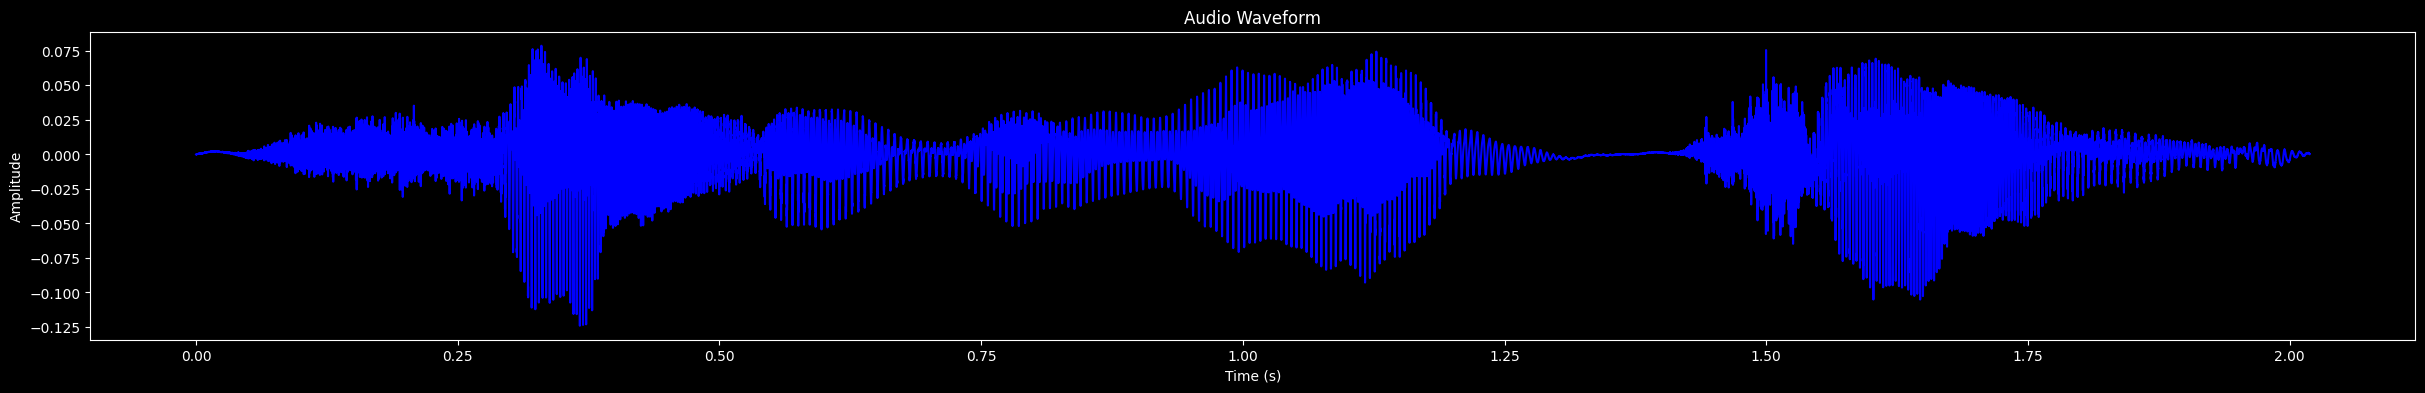

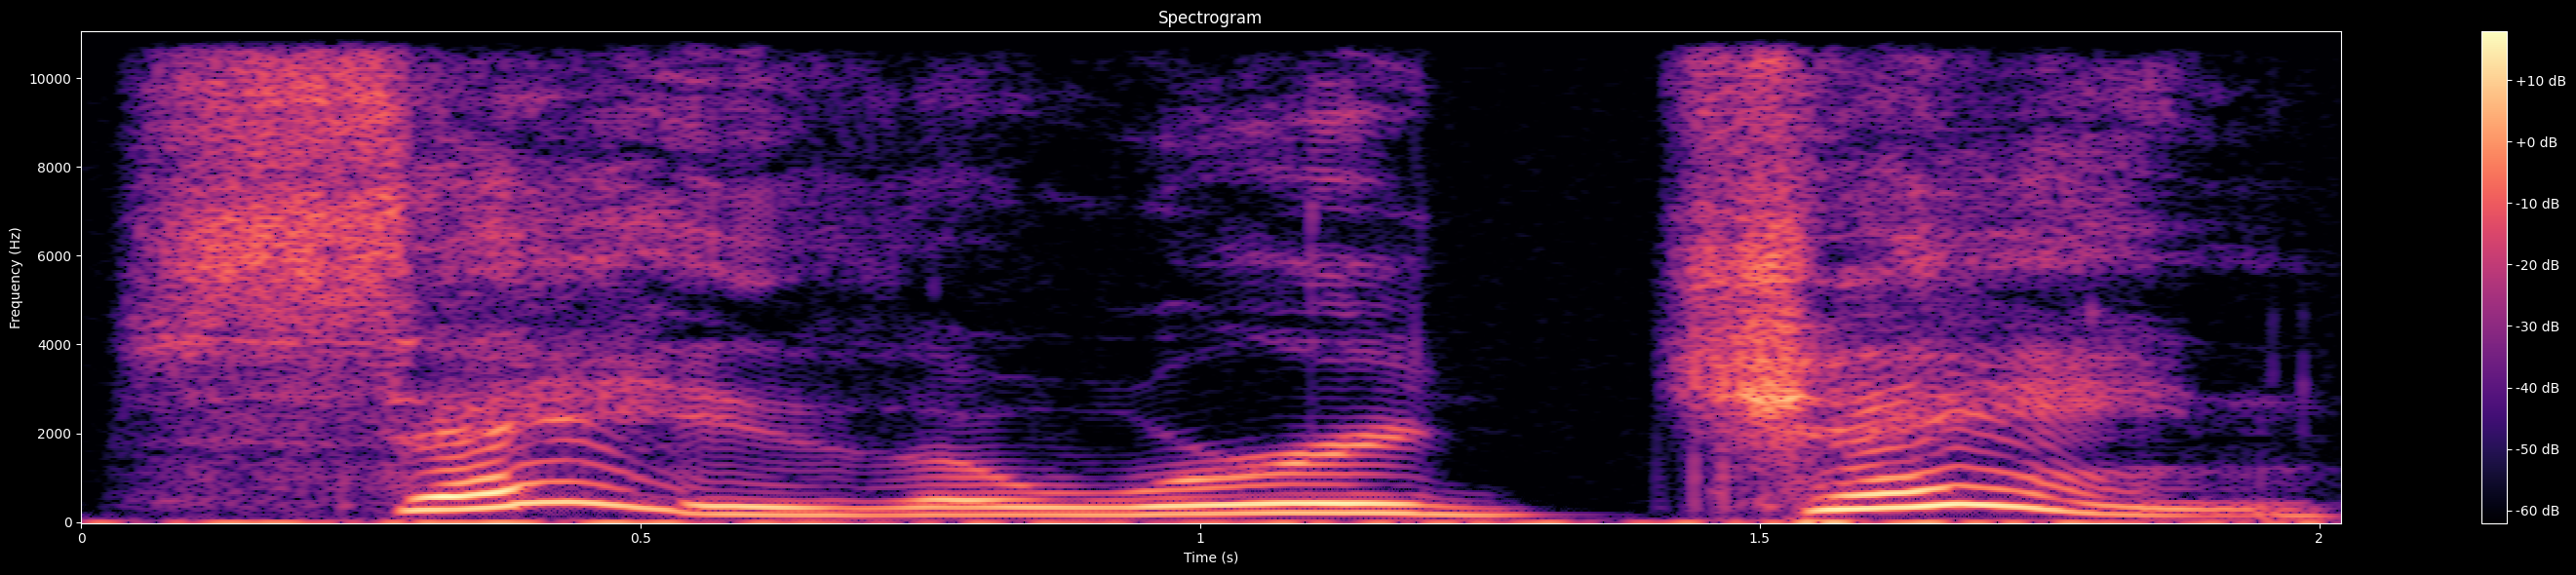

In [ ]:
audio_analysis('/content/raw_audio_data/Happy/OAF_chain_happy.wav')
Audio('/content/raw_audio_data/Happy/OAF_chain_happy.wav')

In [ ]:
# Path to the directory containing your audio dataset
dataset_dir = '/content/raw_audio_data'
# Initialize an empty dictionary to store the mapping between audio files and labels
label_mapping = {}
# Iterate over subdirectories (classes) in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    # Check if the item in the dataset directory is a directory
    if os.path.isdir(label_dir):
        # Iterate over audio files in the subdirectory (class)
        for audio_file in os.listdir(label_dir):
            # Add the mapping between audio file path and label to the dictionary
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label

In [ ]:
# Create a list of tuples containing the audio file paths and labels
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
# Create a Pandas DataFrame from the list of tuples
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])
annotated_data

,audio_file_path,label
0,/content/raw_audio_data/Angry/OAF_jar_angry.wav,Angry
1,/content/raw_audio_data/Angry/YAF_mode_angry.wav,Angry
2,/content/raw_audio_data/Angry/YAF_good_angry.wav,Angry
3,/content/raw_audio_data/Angry/OAF_laud_angry.wav,Angry
4,/content/raw_audio_data/Angry/YAF_tire_angry.wav,Angry
...,...,...
2795,/content/raw_audio_data/Neutral/YAF_page_neutr...,Neutral
2796,/content/raw_audio_data/Neutral/YAF_vote_neutr...,Neutral
2797,/content/raw_audio_data/Neutral/OAF_search_neu...,Neutral
2798,/content/raw_audio_data/Neutral/YAF_soup_neutr...,Neutral


In [ ]:
# Function to extract features from audio file
def extract_features(file_path):
    # Load audio file
    audio, sample_rate = librosa.load(file_path)
    # Extract features using Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Flatten the features into a 1D array
    flattened_features = np.mean(mfccs.T, axis=0)
    return flattened_features

# Function to load dataset and extract features
def load_data_and_extract_features(data_dir):
    labels = []
    features = []
    # Loop through each audio file in the dataset directory
    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(data_dir, filename)
            # Extract label from filename
            label = filename.split('-')[0]
            labels.append(label)
            # Extract features from audio file
            feature = extract_features(file_path)
            features.append(feature)
    return np.array(features), np.array(labels)

In [ ]:
extracted_features = []

for i in annotated_data['audio_file_path']:
    features = extract_features(file_path=i)
    # print(features)
    extracted_features.append(features)

In [ ]:
label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])
annotated_data

,audio_file_path,label,encoded_label
0,/content/raw_audio_data/Angry/OAF_jar_angry.wav,Angry,0
1,/content/raw_audio_data/Angry/YAF_mode_angry.wav,Angry,0
2,/content/raw_audio_data/Angry/YAF_good_angry.wav,Angry,0
3,/content/raw_audio_data/Angry/OAF_laud_angry.wav,Angry,0
4,/content/raw_audio_data/Angry/YAF_tire_angry.wav,Angry,0
...,...,...,...
2795,/content/raw_audio_data/Neutral/YAF_page_neutr...,Neutral,4
2796,/content/raw_audio_data/Neutral/YAF_vote_neutr...,Neutral,4
2797,/content/raw_audio_data/Neutral/OAF_search_neu...,Neutral,4
2798,/content/raw_audio_data/Neutral/YAF_soup_neutr...,Neutral,4


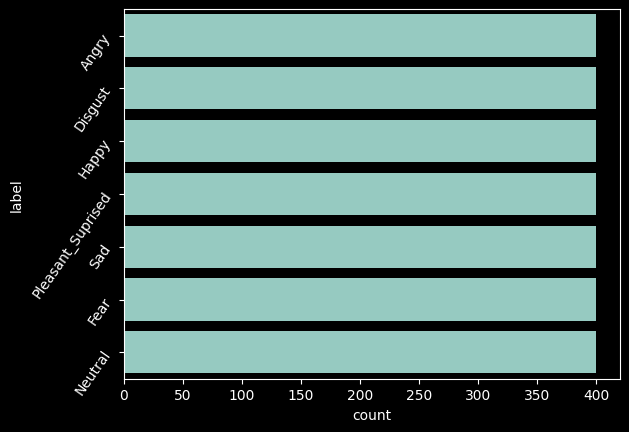

In [ ]:
sns.countplot(annotated_data['label'])
plt.yticks(rotation=55)
plt.show()

In [ ]:
x = extracted_features
y = annotated_data['encoded_label']

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
random_forest_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
random_forest_model = random_forest_classifier.fit(x_train, y_train)
y_predict = random_forest_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.9785714285714285


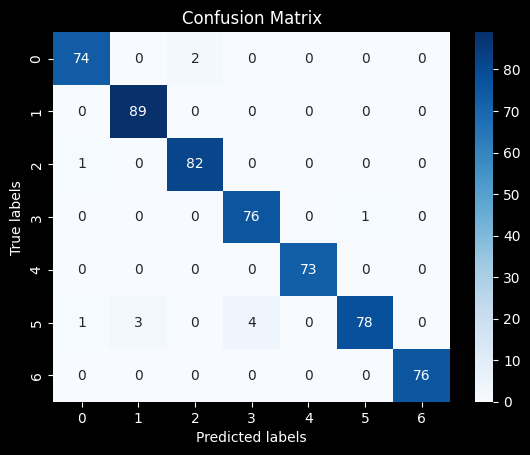

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_predict)
# Plot the confusion matrix
sns.heatmap(confusion_matrix, cmap=plt.cm.Blues, annot=True)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# import pickle
# pickle.dump(random_forest_model, open('audio_classifier_model.pkl', 'wb'))

In [ ]:
# model_path = '/content/audio_classifier_model.pkl'
# model = pickle.load(open(model_path, 'rb'))

In [ ]:
from joblib import dump, load
dump(clf, 'audio_classifier_model.joblib')

In [ ]:
model = load('audio_classifier_model.joblib')

In [ ]:
audio = '/content/raw_audio_data/Happy/OAF_dodge_happy.wav'
print(audio)
extracted_features = extract_features(audio).reshape(1, -1)
# extracted_features = x_test[112].reshape(1, -1)
y_predict = model.predict(extracted_features)
labels_list = annotated_data['label'].unique()
encoded_label = annotated_data['encoded_label'].unique()

labels = {}
for label, prediction in zip(encoded_label, labels_list):
    labels[label] = prediction
if y_predict[0] in labels.keys():
    print('Predicted Class:', labels[y_predict[0]])

/content/raw_audio_data/Happy/OAF_dodge_happy.wav
Predicted Class: Happy
